# **Timed Quantum-Fuzzy Inspired Fault Detection on SKAB Dataset**

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Callable, Dict, Any, List, Tuple, Optional
import time
import os
import skfuzzy as fuzz
import QFIE.FuzzyEngines as FE
import scipy.linalg as la
from skfuzzy.defuzzify.exceptions import EmptyMembershipError
from sklearn.preprocessing import MinMaxScaler
import membership
import rule_base
import mamdani
import wangmendel
import defuzz
from Examples.MackeyGlass import synthetic
from sklearn.metrics import roc_curve, auc

# **1. Load SKAB Data**

In [3]:
def load_skab():
    path_to_data = "skab_data/"
    # benchmark files checking
    all_files = []

    for root, dirs, files in os.walk(path_to_data):
        for file in files:
            if file.endswith(".csv"):
                all_files.append(os.path.join(root, file))

    # datasets with anomalies loading
    list_of_df = [
        pd.read_csv(file, sep=";", index_col="datetime", parse_dates=True)
        for file in all_files
        if "anomaly-free" not in file
    ]
    
    # anomaly-free df loading
    anomaly_free_df = pd.read_csv(
        [file for file in all_files if "anomaly-free" in file][0],
        sep=";",
        index_col="datetime",
        parse_dates=True,
    )

    return list_of_df, anomaly_free_df

list_of_df, anomaly_free_df = load_skab()
df = list_of_df[0]
display(list_of_df[0])
display(anomaly_free_df)

def split_normal_dataset(df_normale, n_segments=5):
    segment_size = len(df_normale) // n_segments
    segments = []
    for i in range(n_segments):
        start = i * segment_size
        # L'ultimo prende tutto ciò che resta (così copriamo anche eventuale resto della divisione)
        end = (i + 1) * segment_size if i < n_segments - 1 else len(df_normale)
        segment = df_normale.iloc[start:end]
        segments.append(segment)
    return segments


def plot_all_segmented_features(df_originale, segments, feature_names):
    n_features = len(feature_names)
    plt.figure(figsize=(14, 6 * n_features))
    
    # Calcola i punti di separazione usando la lunghezza dei segmenti
    cumulative_lengths = [len(seg) for seg in segments]
    split_indices = [sum(cumulative_lengths[:i]) for i in range(1, len(cumulative_lengths))]

    for i, feature_name in enumerate(feature_names):
        plt.subplot(n_features, 1, i+1)  # Un subplot per ogni feature
        plt.plot(df_originale.index, df_originale[feature_name], label=feature_name)
        
        for idx in split_indices:
            split_time = df_originale.index[idx]
            plt.axvline(x=split_time, color='red', linestyle='--', label='Segment boundary' if i == 0 else "")
        
        plt.title(f'Segmentazione della serie su "{feature_name}"')
        plt.xlabel("Tempo")
        plt.ylabel(feature_name)
        plt.grid(True)
        plt.tight_layout()

    plt.show()

Accelerometer1RMS  Accelerometer2RMS  Current  Pressure  \
datetime                                                                       
2020-02-08 16:47:11           0.213089           0.260424  1.44922 -0.273216   
2020-02-08 16:47:12           0.211211           0.257295  2.48733 -0.273216   
2020-02-08 16:47:13           0.208962           0.254713  2.64975  0.382638   
2020-02-08 16:47:14           0.211292           0.256228  2.94410  0.054711   
2020-02-08 16:47:15           0.217600           0.261785  2.38798  0.382638   
...                                ...                ...      ...       ...   
2020-02-08 17:06:08           0.222106           0.263904  2.17658  0.382638   
2020-02-08 17:06:09           0.222804           0.265610  2.38372  0.054711   
2020-02-08 17:06:10           0.222702           0.271478  2.37550 -0.273216   
2020-02-08 17:06:11           0.219204           0.265277  2.25808  0.382638   
2020-02-08 17:06:12           0.221849           0.266916  2.35537  0.382638   

                     Temperature  Thermocouple  Voltage  Volume Flow RateRMS  \
datetime                                                                       
2020-02-08 16:47:11      88.3793       29.7245  203.410              128.000   
2020-02-08 16:47:12      89.0805       29.7245  223.716              127.320   
2020-02-08 16:47:13      88.4958       29.7161  236.980              127.000   
2020-02-08 16:47:14      88.4240       29.7121  248.692              127.681   
2020-02-08 16:47:15      88.4550       29.7184  222.620              128.000   
...                          ...           ...      ...                  ...   
2020-02-08 17:06:08      88.3026       29.8332  214.814              127.319   
2020-02-08 17:06:09      88.3000       29.8287  228.293              127.683   
2020-02-08 17:06:10      88.1713       29.8370  201.892              128.000   
2020-02-08 17:06:11      88.0136       29.8369  227.780              127.319   
2020-02-08 17:06:12      88.2410       29.8307  223.293              127.683   

                     anomaly  changepoint  
datetime                                   
2020-02-08 16:47:11      0.0          0.0  
2020-02-08 16:47:12      0.0          0.0  
2020-02-08 16:47:13      0.0          0.0  
2020-02-08 16:47:14      0.0          0.0  
2020-02-08 16:47:15      0.0          0.0  
...                      ...          ...  
2020-02-08 17:06:08      0.0          0.0  
2020-02-08 17:06:09      0.0          0.0  
2020-02-08 17:06:10      0.0          0.0  
2020-02-08 17:06:11      0.0          0.0  
2020-02-08 17:06:12      0.0          0.0  

[1090 rows x 10 columns]

Accelerometer1RMS  Accelerometer2RMS  Current  Pressure  \
datetime                                                                       
2020-02-08 13:30:47           0.202394           0.275154  2.16975  0.382638   
2020-02-08 13:30:48           0.203153           0.277857  2.07999 -0.273216   
2020-02-08 13:30:50           0.202054           0.275790  2.52577  0.382638   
2020-02-08 13:30:51           0.203595           0.278101  2.49742  0.054711   
2020-02-08 13:30:52           0.201889           0.276363  2.29194  0.710565   
...                                ...                ...      ...       ...   
2020-02-08 16:16:43           0.225744           0.267921  2.91598  0.054711   
2020-02-08 16:16:44           0.205870           0.258370  1.71505  0.710565   
2020-02-08 16:16:45           0.219222           0.267244  2.35834 -0.273216   
2020-02-08 16:16:46           0.219481           0.271278  2.49108  0.054711   
2020-02-08 16:16:47           0.219436           0.270046  2.43108  0.382638   

                     Temperature  Thermocouple  Voltage  Volume Flow RateRMS  
datetime                                                                      
2020-02-08 13:30:47      90.6454       26.8508  238.852              122.664  
2020-02-08 13:30:48      90.7978       26.8639  227.943              122.338  
2020-02-08 13:30:50      90.7730       26.8603  223.486              121.338  
2020-02-08 13:30:51      90.8424       26.8616  244.904              121.664  
2020-02-08 13:30:52      90.6664       26.8603  239.196              122.000  
...                          ...           ...      ...                  ...  
2020-02-08 16:16:43      88.8593       29.3792  219.542              126.000  
2020-02-08 16:16:44      89.1754       29.3692  221.862              126.000  
2020-02-08 16:16:45      89.1306       29.3674  226.050              126.679  
2020-02-08 16:16:46      88.5447       29.3757  226.343              127.000  
2020-02-08 16:16:47      89.1161       29.3687  205.473              125.648  

[9405 rows x 8 columns]

# **2. Plot Smoothing Data**

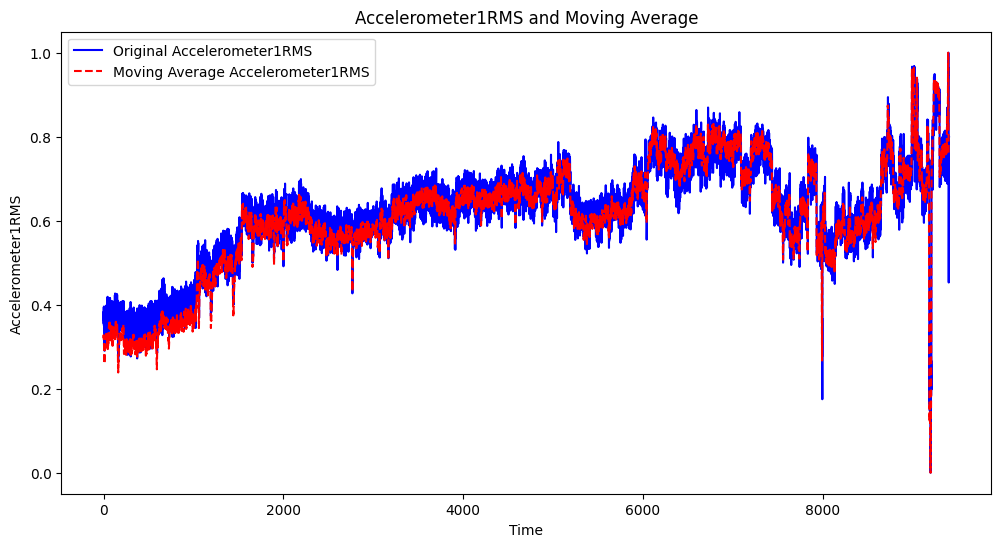

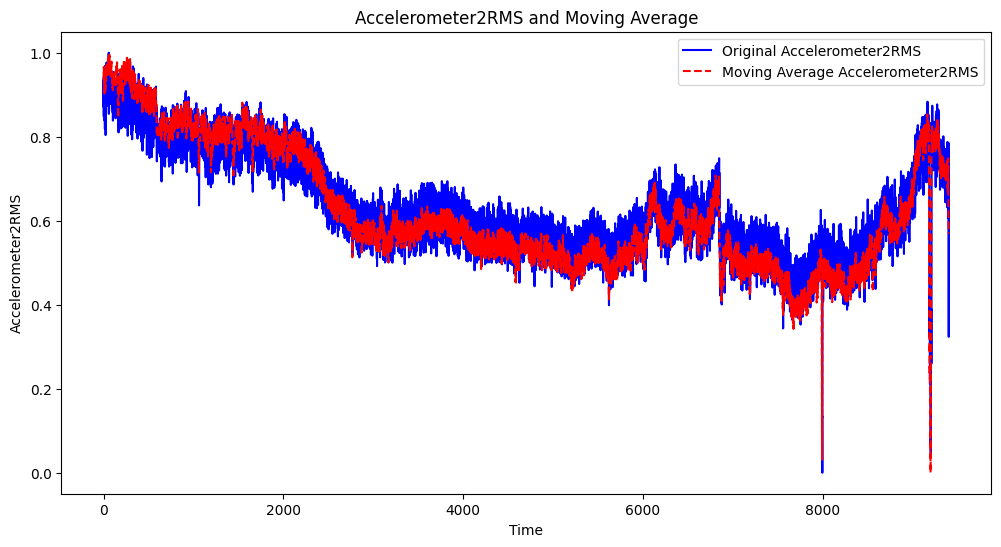

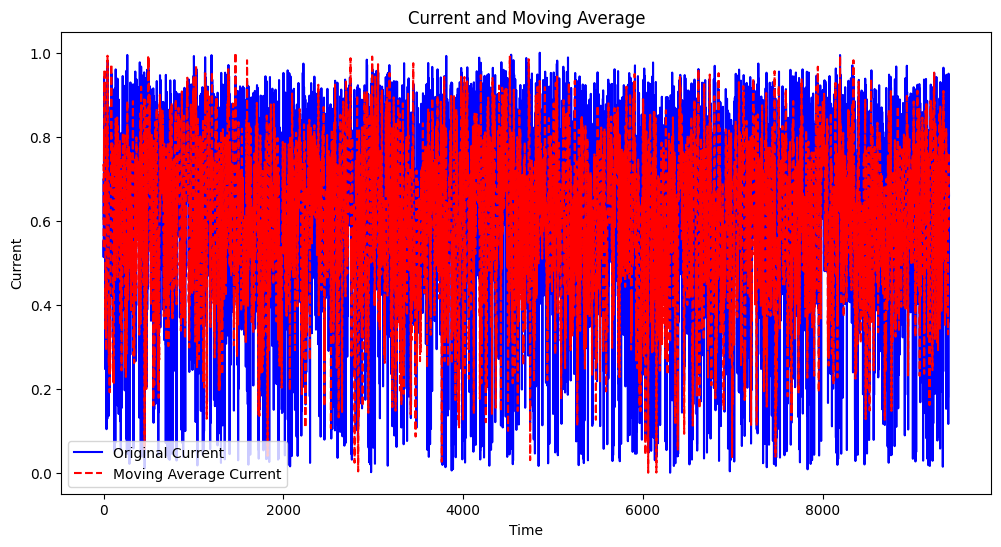

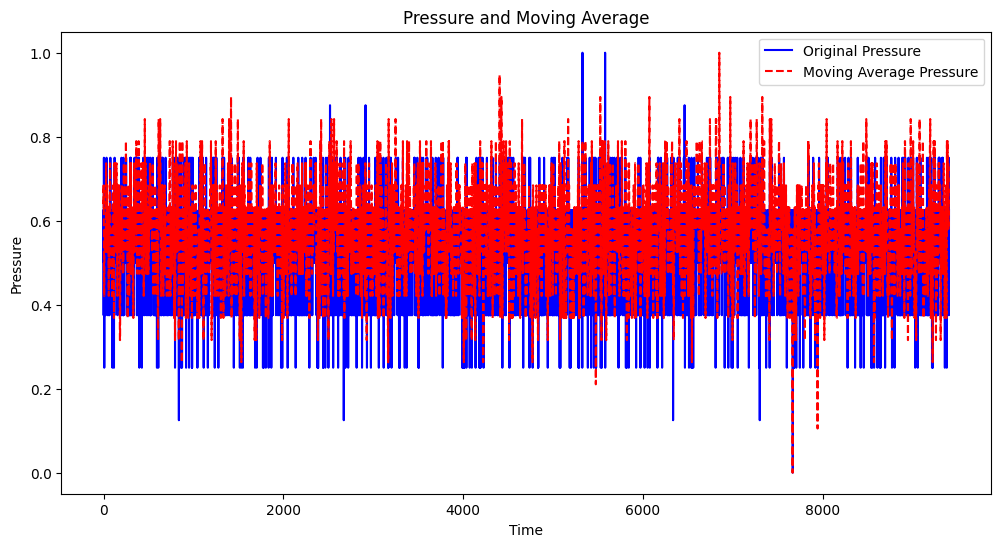

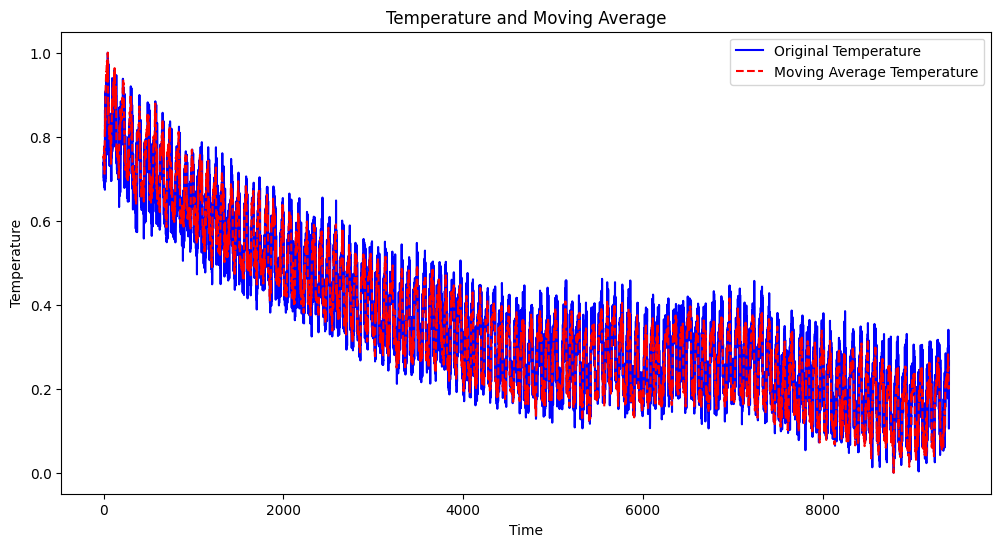

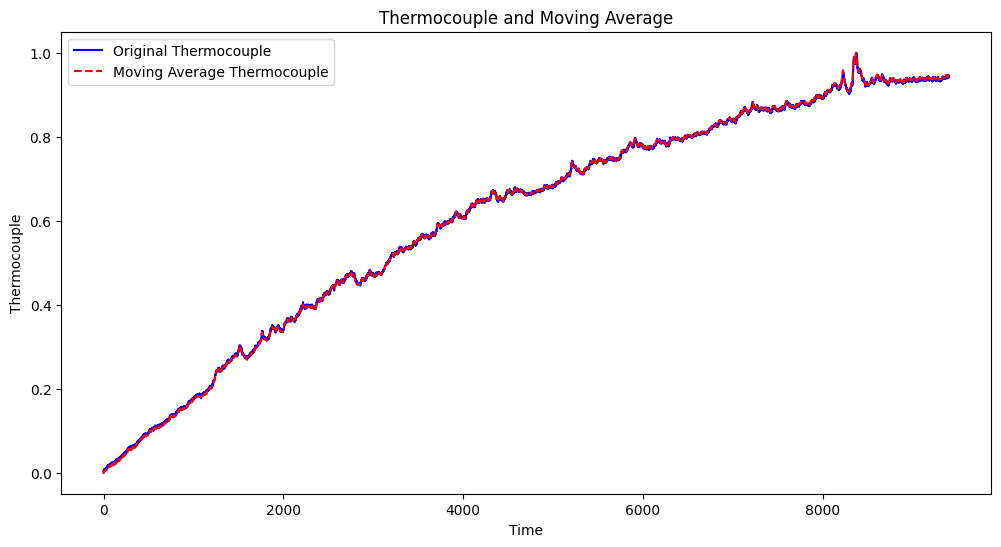

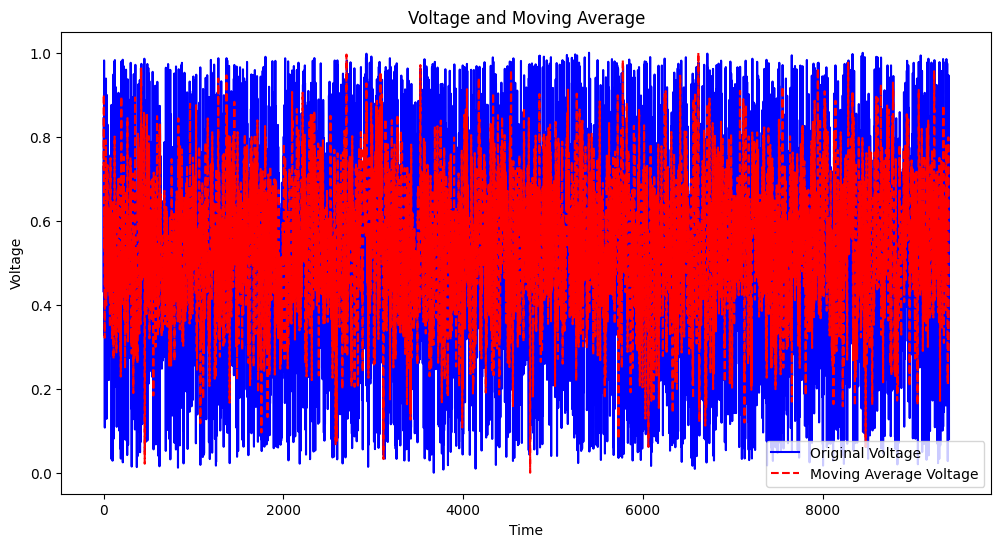

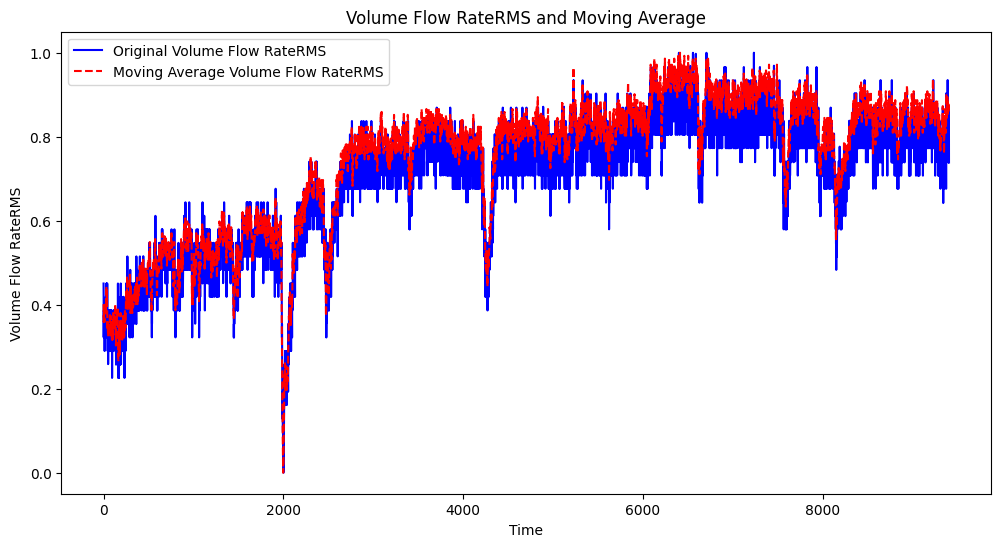

In [4]:
numerical_columns = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure', 'Temperature', 
                     'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

df_numeric = anomaly_free_df[numerical_columns]

# Calcolare la media mobile
df_moving_avg_n = df_numeric.rolling(window=5).mean()

# Rimuovere i NaN che risultano dalla media mobile
df_moving_avg_n = df_moving_avg_n.dropna()

# Normalizzare i dati originali con MinMaxScaler
scaler = MinMaxScaler()
df_numeric_n = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

# Normalizzare la media mobile con MinMaxScaler
df_moving_avg_n = pd.DataFrame(scaler.fit_transform(df_moving_avg_n), columns=df_moving_avg_n.columns)

# Plot
for col in df_numeric.columns:
    plt.figure(figsize=(12, 6))
    
    # Tracciare i dati originali normalizzati
    plt.plot(df_numeric_n.index, df_numeric_n[col], label=f'Original {col}', color='blue')
    
    # Tracciare i dati della media mobile normalizzati
    plt.plot(df_moving_avg_n.index, df_moving_avg_n[col], label=f'Moving Average {col}', color='red', linestyle='--')
    
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.title(f'{col} and Moving Average')
    plt.legend()
    plt.show()

# **3. Time Series Partitioning Through Change Point Analysis**

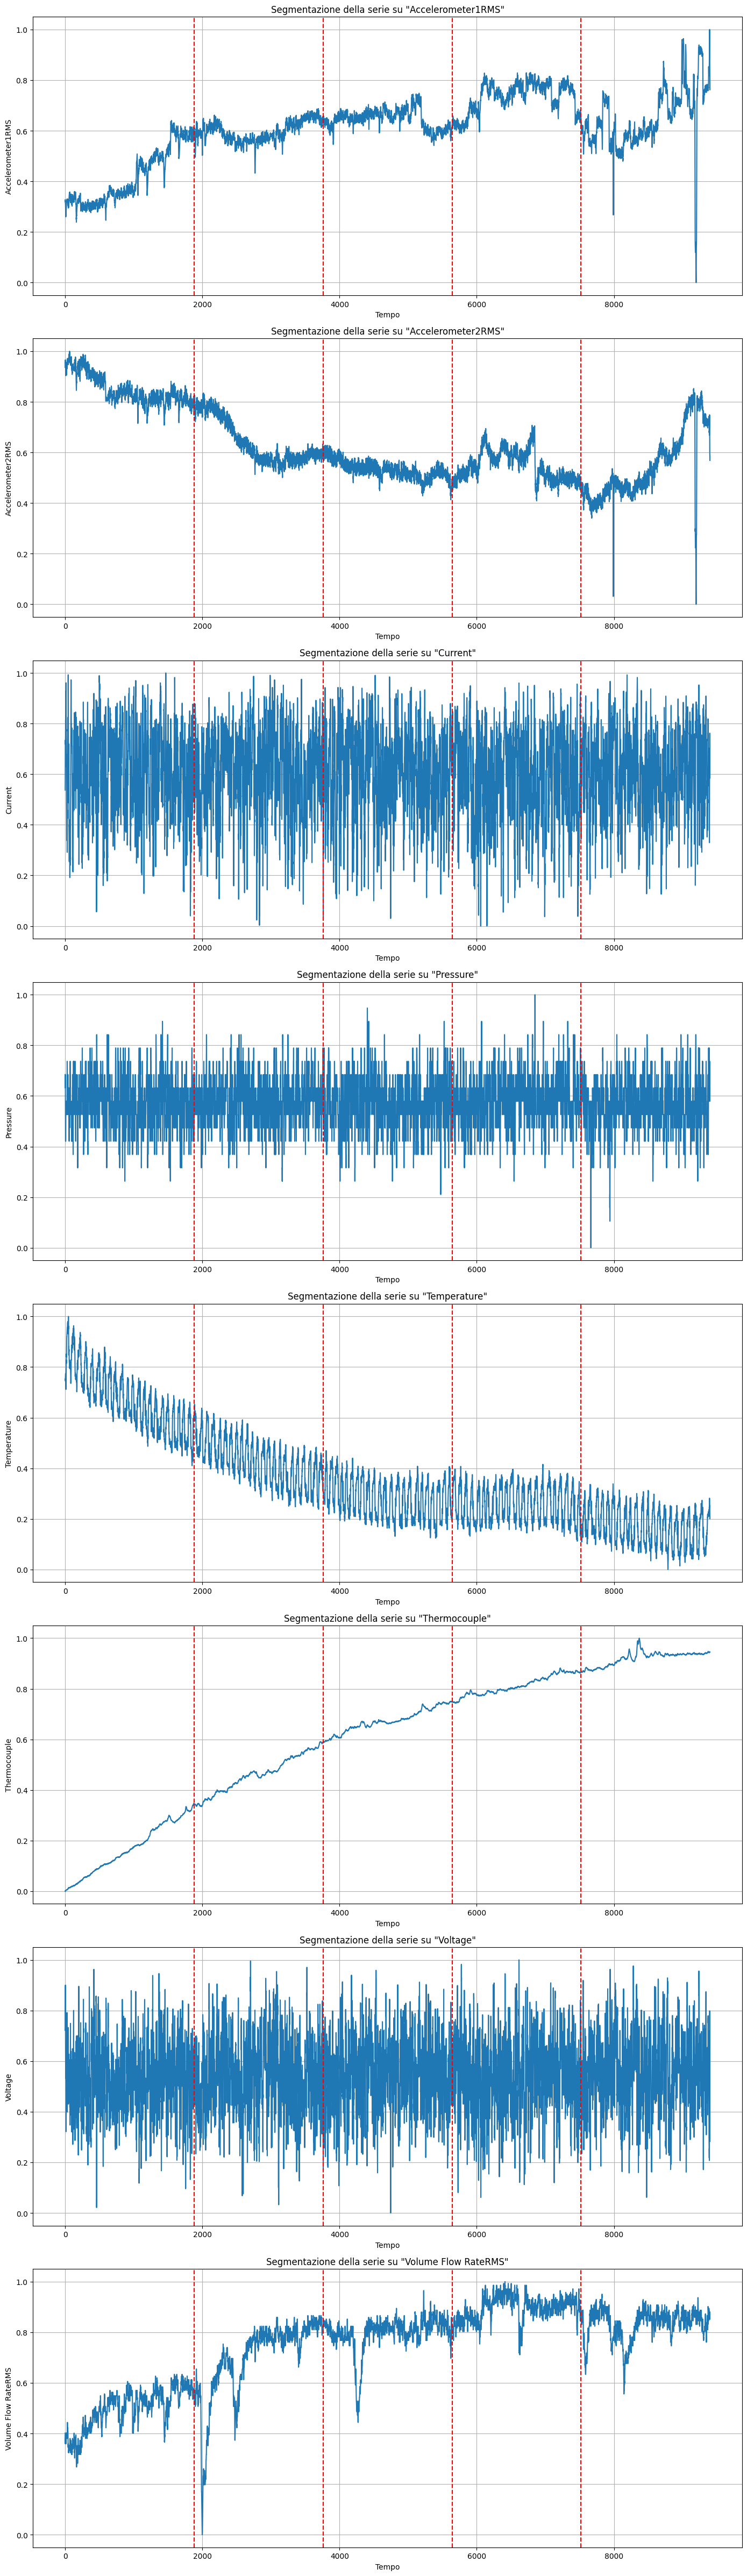

In [5]:
normal_segments = split_normal_dataset(df_moving_avg_n,5)
plot_all_segmented_features(df_moving_avg_n,normal_segments,numerical_columns)

# **4. Plot Segmented Smoothed Data**

Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  Temperature  \
0              0.594887           0.260844  0.298684  0.263159     0.135776   
1              0.535451           0.152483  0.714211  0.526316     0.153422   
2              0.536618           0.132238  0.872308  0.657895     0.053983   
3              0.661019           0.266422  0.781704  0.657895     0.047803   
4              0.737276           0.401840  0.650958  0.789474     0.042911   
...                 ...                ...       ...       ...          ...   
1084           0.874870           0.477337  0.546661  0.526316    -0.002651   
1085           0.891705           0.484642  0.514576  0.657895     0.005938   
1086           0.900289           0.628352  0.583426  0.394737    -0.013950   
1087           0.848443           0.622033  0.539940  0.526316    -0.057331   
1088           0.836158           0.535474  0.532972  0.789474    -0.046773   

      Thermocouple   Voltage  Volume Flow RateRMS  
0         1.077810  0.099444             0.998986  
1         1.076230  0.589683             0.946185  
2         1.073897  0.954420             0.965246  
3         1.074330  0.744714             1.018048  
4         1.075609  0.511175             0.998986  
...            ...       ...                  ...  
1084      1.118193  0.339773             0.982195  
1085      1.117854  0.332822             0.982195  
1086      1.118569  0.144116             1.018153  
1087      1.120112  0.136624             0.998933  
1088      1.118927  0.449154             0.982195  

[1089 rows x 8 columns]

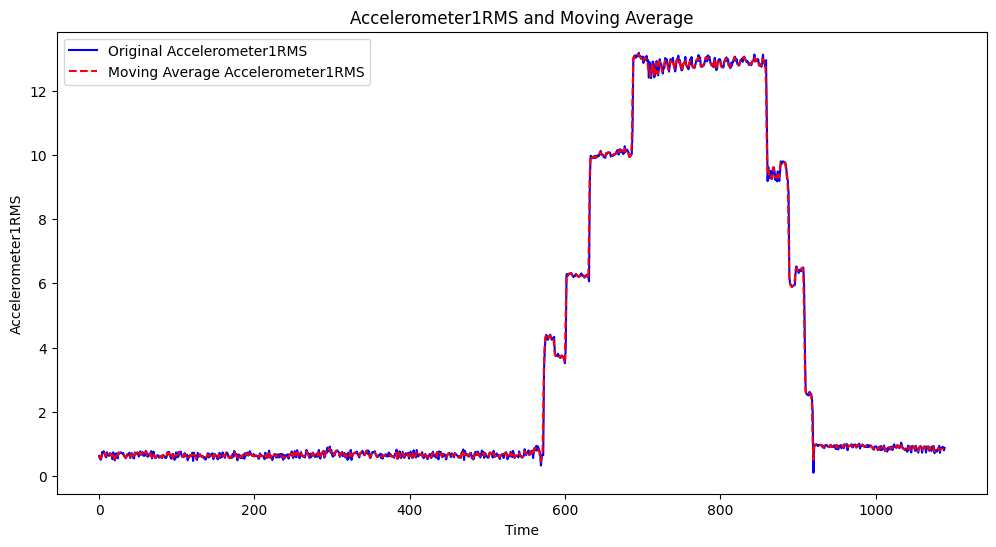

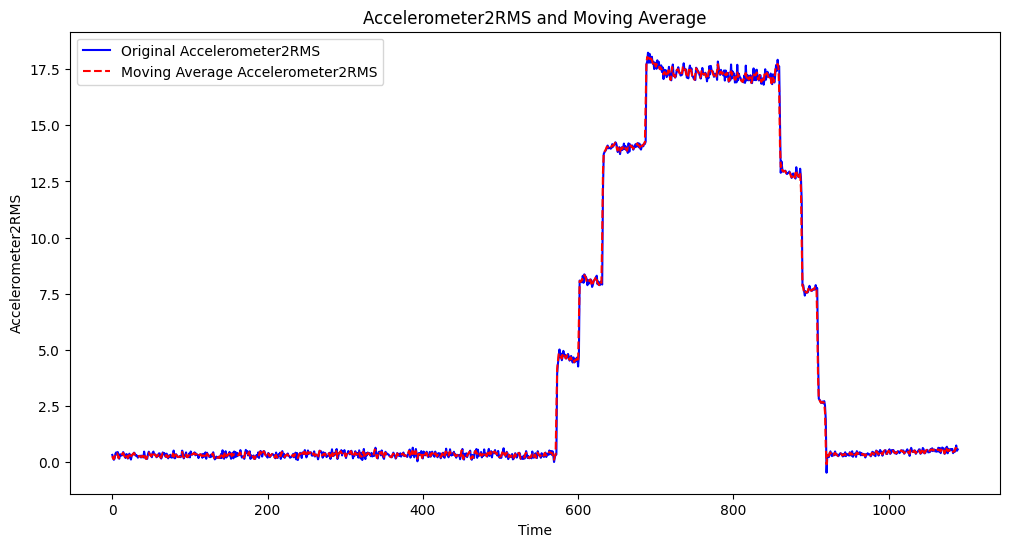

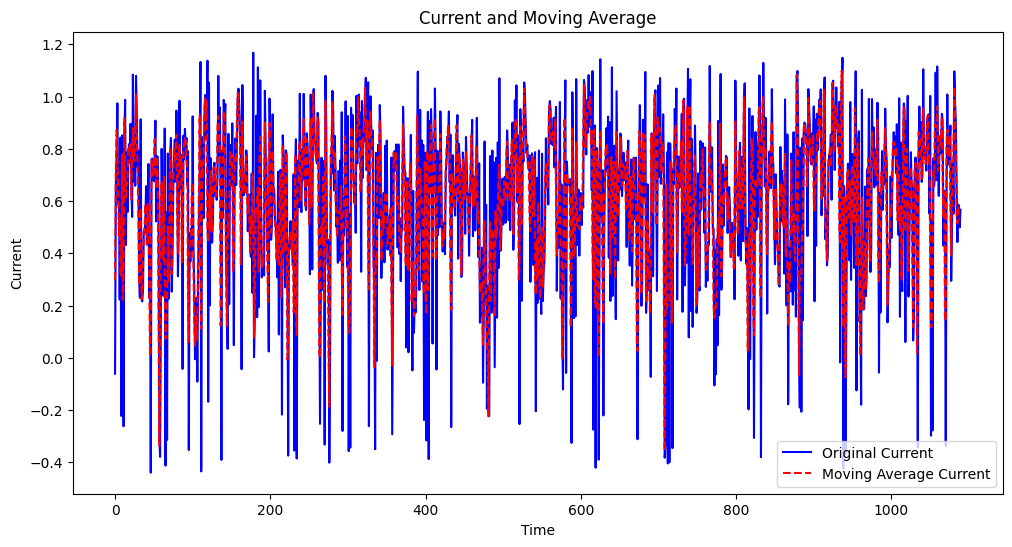

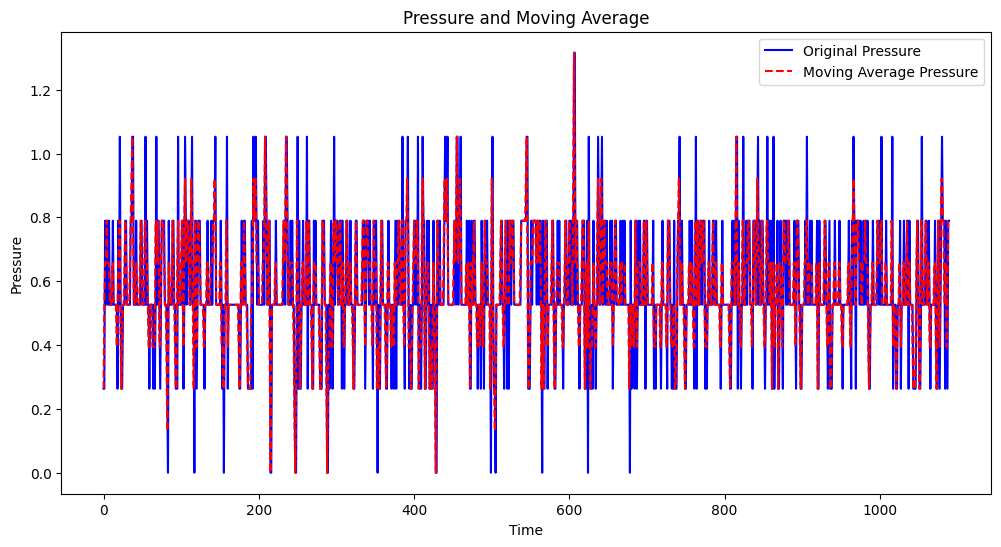

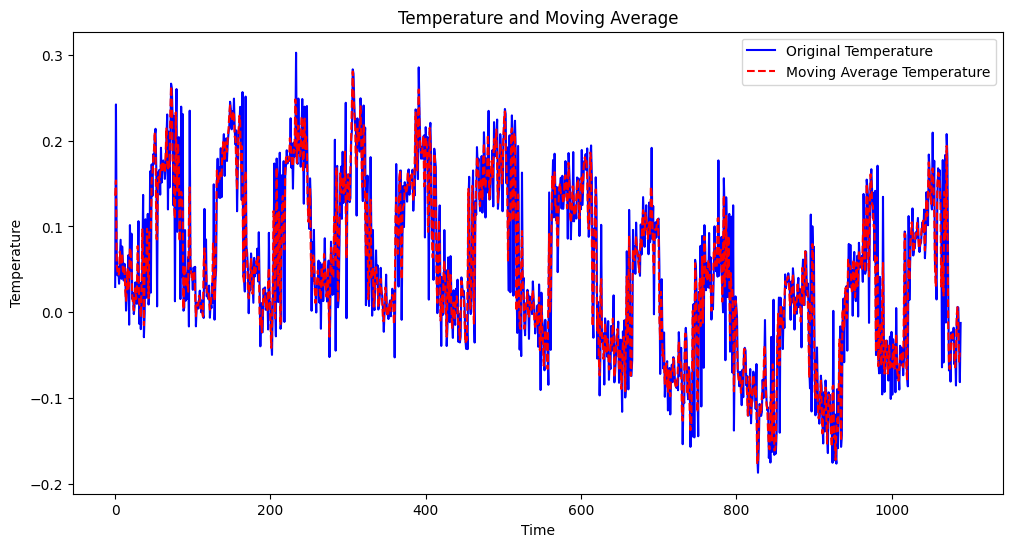

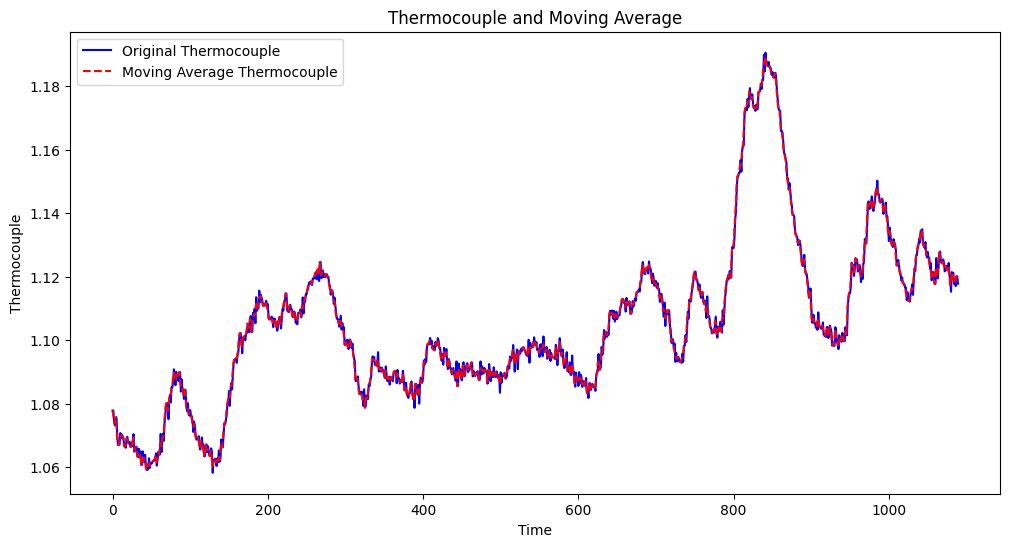

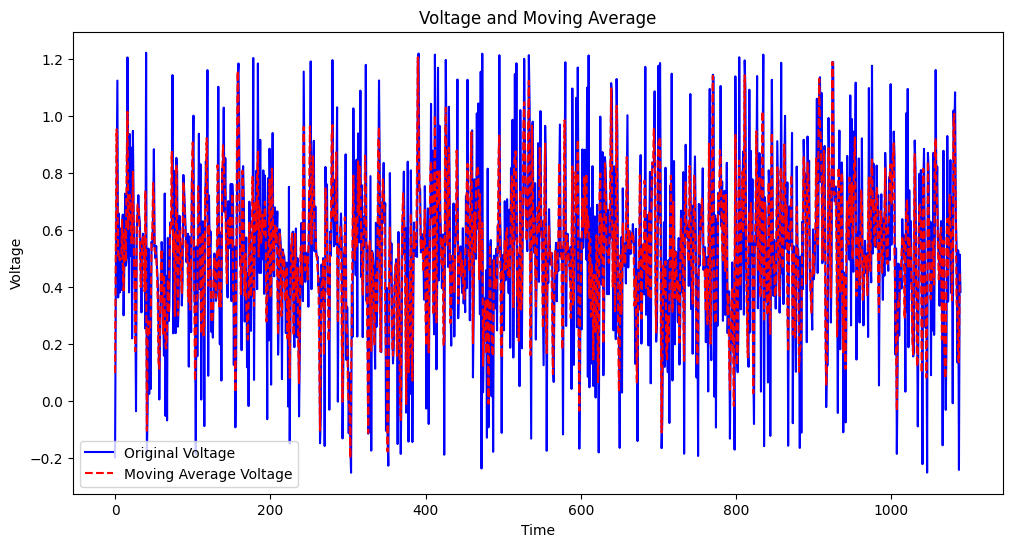

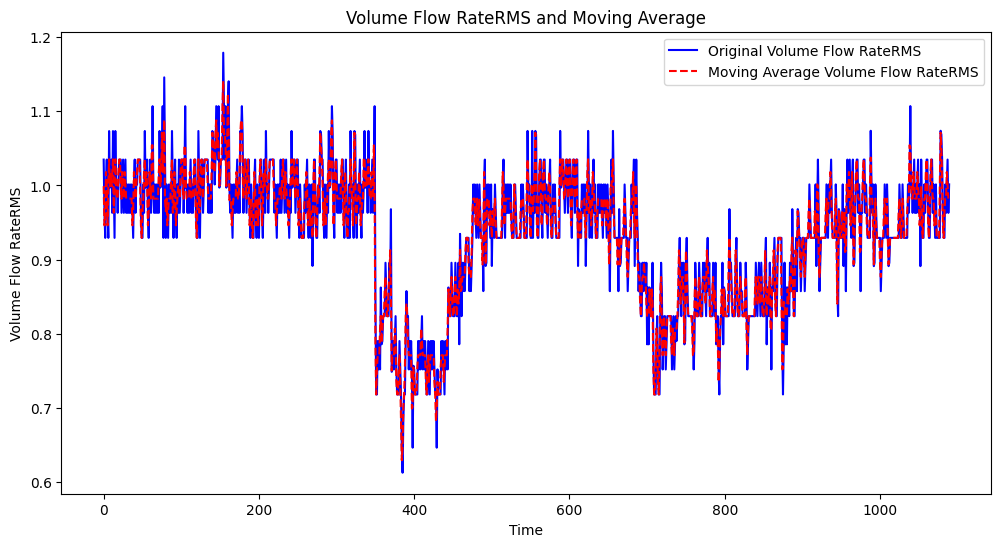

In [6]:
# Dati numerici
numerical_columns = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure', 'Temperature', 
                     'Thermocouple', 'Voltage', 'Volume Flow RateRMS']
df_numeric_an = df[numerical_columns]

# Applica la media mobile con una finestra di 5
df_moving_avg = df_numeric_an.rolling(window=2).mean()

# Rimuovere i NaN che risultano dalla media mobile
df_moving_avg = df_moving_avg.dropna()

# Normalizzare i dati originali con MinMaxScaler
df_numeric_an = pd.DataFrame(scaler.transform(df_numeric_an), columns=df_numeric_an.columns)
# Normalizzare la media mobile con MinMaxScaler
df_moving_avg = pd.DataFrame(scaler.transform(df_moving_avg), columns=df_moving_avg.columns)

# Visualizzare la media mobile normalizzata
display(df_moving_avg)

# Plot dei dati
for col in df_numeric.columns:
    plt.figure(figsize=(12, 6))
    
    # Tracciare i dati originali normalizzati
    plt.plot(df_numeric_an.index, df_numeric_an[col], label=f'Original {col}', color='blue')
    
    # Tracciare i dati della media mobile normalizzati
    plt.plot(df_moving_avg.index, df_moving_avg[col], label=f'Moving Average {col}', color='red', linestyle='--')
    
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.title(f'{col} and Moving Average')
    plt.legend()
    plt.show()


# **5. Display Segmentad Data**

segment_1: (569, 10)


Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-02-08 16:47:15           0.042771           0.039524  0.759924  0.500001   
2020-02-08 16:47:16           0.048599           0.046765  0.678568  0.600001   
2020-02-08 16:47:17           0.049360           0.045630  0.564621  0.500001   
2020-02-08 16:47:18           0.048987           0.046124  0.605048  0.500001   
2020-02-08 16:47:19           0.044285           0.042666  0.466542  0.500001   
...                                ...                ...       ...       ...   
2020-02-08 16:57:06           0.049593           0.046215  0.843506  0.200000   
2020-02-08 16:57:08           0.031506           0.033385  0.652143  0.400000   
2020-02-08 16:57:09           0.027001           0.031055  0.516958  0.600001   
2020-02-08 16:57:10           0.039992           0.039926  0.568207  0.600001   
2020-02-08 16:57:11           0.042609           0.043399  0.571857  0.400000   

                     Temperature  Thermocouple   Voltage  Volume Flow RateRMS  \
datetime                                                                        
2020-02-08 16:47:15     0.479581      0.121802  0.675401             0.715843   
2020-02-08 16:47:16     0.469573      0.131467  0.517033             0.682199   
2020-02-08 16:47:17     0.474469      0.112706  0.523014             0.589003   
2020-02-08 16:47:18     0.526802      0.079591  0.505278             0.686300   
2020-02-08 16:47:19     0.508180      0.066373  0.508219             0.746226   
...                          ...           ...       ...                  ...   
2020-02-08 16:57:06     0.636271      0.274872  0.527807             0.745573   
2020-02-08 16:57:08     0.640516      0.274304  0.477728             0.682106   
2020-02-08 16:57:09     0.578794      0.272172  0.472183             0.652470   
2020-02-08 16:57:10     0.534951      0.287521  0.508338             0.652470   
2020-02-08 16:57:11     0.636302      0.296617  0.564478             0.588910   

                     anomaly  
datetime                      
2020-02-08 16:47:15      0.0  
2020-02-08 16:47:16      0.0  
2020-02-08 16:47:17      0.0  
2020-02-08 16:47:18      0.0  
2020-02-08 16:47:19      0.0  
...                      ...  
2020-02-08 16:57:06      0.0  
2020-02-08 16:57:08      0.0  
2020-02-08 16:57:09      0.0  
2020-02-08 16:57:10      0.0  
2020-02-08 16:57:11      1.0  

[569 rows x 9 columns]

segment_2: (119, 10)


Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-02-08 16:57:12           0.142902           0.139526  0.745412  0.300000   
2020-02-08 16:57:13           0.269092           0.247620  0.648587  0.400000   
2020-02-08 16:57:14           0.308310           0.267091  0.550379  0.400000   
2020-02-08 16:57:15           0.325315           0.283937  0.513641  0.400000   
2020-02-08 16:57:16           0.323699           0.284067  0.269581  0.400000   
...                                ...                ...       ...       ...   
2020-02-08 16:59:11           0.785413           0.785369  0.601033  0.400000   
2020-02-08 16:59:12           0.898424           0.879867  0.474405  0.300000   
2020-02-08 16:59:13           0.987653           0.975645  0.481112  0.500001   
2020-02-08 16:59:14           0.992249           0.989798  0.378443  0.500001   
2020-02-08 16:59:15           0.990579           0.988139  0.517979  0.500001   

                     Temperature  Thermocouple   Voltage  Volume Flow RateRMS  \
datetime                                                                        
2020-02-08 16:57:12     0.678007      0.272456  0.738800             0.618919   
2020-02-08 16:57:13     0.689007      0.273024  0.671985             0.682479   
2020-02-08 16:57:14     0.665644      0.289937  0.526827             0.715937   
2020-02-08 16:57:15     0.667968      0.305145  0.516280             0.682106   
2020-02-08 16:57:16     0.667596      0.310688  0.292533             0.588910   
...                          ...           ...       ...                  ...   
2020-02-08 16:59:11     0.556950      0.477828  0.458457             0.682106   
2020-02-08 16:59:12     0.581862      0.485219  0.417776             0.588910   
2020-02-08 16:59:13     0.596084      0.488488  0.624302             0.495713   
2020-02-08 16:59:14     0.569065      0.481524  0.464557             0.466076   
2020-02-08 16:59:15     0.681477      0.488488  0.412765             0.466076   

                     anomaly  
datetime                      
2020-02-08 16:57:12      1.0  
2020-02-08 16:57:13      1.0  
2020-02-08 16:57:14      1.0  
2020-02-08 16:57:15      1.0  
2020-02-08 16:57:16      1.0  
...                      ...  
2020-02-08 16:59:11      1.0  
2020-02-08 16:59:12      1.0  
2020-02-08 16:59:13      1.0  
2020-02-08 16:59:14      1.0  
2020-02-08 16:59:15      1.0  

[119 rows x 9 columns]

segment_3: (168, 10)


Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-02-08 16:59:16           0.990853           0.986906  0.804863  0.500001   
2020-02-08 16:59:18           0.992577           0.986943  0.634829  0.400000   
2020-02-08 16:59:19           0.991227           0.979139  0.616019  0.400000   
2020-02-08 16:59:20           0.995651           0.986187  0.827117  0.400000   
2020-02-08 16:59:21           0.995776           0.982393  0.900327  0.500001   
...                                ...                ...       ...       ...   
2020-02-08 17:02:07           0.985543           0.960281  0.490362  0.600001   
2020-02-08 17:02:08           0.986117           0.963641  0.444689  0.600001   
2020-02-08 17:02:09           0.977549           0.969963  0.609351  0.500001   
2020-02-08 17:02:10           0.972126           0.973175  0.686701  0.500001   
2020-02-08 17:02:12           0.974085           0.965347  0.658287  0.400000   

                     Temperature  Thermocouple   Voltage  Volume Flow RateRMS  \
datetime                                                                        
2020-02-08 16:59:16     0.665024      0.494599  0.675609             0.402516   
2020-02-08 16:59:18     0.595650      0.486356  0.738443             0.372787   
2020-02-08 16:59:19     0.505980      0.479818  0.733393             0.436347   
2020-02-08 16:59:20     0.469697      0.462337  0.818261             0.466076   
2020-02-08 16:59:21     0.579259      0.462621  0.736205             0.466076   
...                          ...           ...       ...                  ...   
2020-02-08 17:02:07     0.378323      0.943292  0.601208             0.373439   
2020-02-08 17:02:08     0.256150      0.919557  0.459140             0.436719   
2020-02-08 17:02:09     0.255996      0.894116  0.420915             0.402516   
2020-02-08 17:02:10     0.399857      0.874787  0.718360             0.436440   
2020-02-08 17:02:12     0.388610      0.864412  0.725401             0.466170   

                     anomaly  
datetime                      
2020-02-08 16:59:16      1.0  
2020-02-08 16:59:18      1.0  
2020-02-08 16:59:19      1.0  
2020-02-08 16:59:20      1.0  
2020-02-08 16:59:21      1.0  
...                      ...  
2020-02-08 17:02:07      1.0  
2020-02-08 17:02:08      1.0  
2020-02-08 17:02:09      1.0  
2020-02-08 17:02:10      1.0  
2020-02-08 17:02:12      1.0  

[168 rows x 9 columns]

segment_4: (60, 10)


Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-02-08 17:02:13           0.915009           0.906241  0.684969  0.500001   
2020-02-08 17:02:14           0.771091           0.779539  0.672590  0.400000   
2020-02-08 17:02:15           0.711229           0.727552  0.584088  0.200000   
2020-02-08 17:02:16           0.721048           0.731910  0.681431  0.500001   
2020-02-08 17:02:17           0.707654           0.719760  0.761839  0.500001   
2020-02-08 17:02:18           0.709864           0.717384  0.516419  0.300000   
2020-02-08 17:02:19           0.708889           0.718082  0.601751  0.400000   
2020-02-08 17:02:20           0.699885           0.718590  0.484299  0.400000   
2020-02-08 17:02:21           0.713475           0.716969  0.349170  0.500001   
2020-02-08 17:02:22           0.726765           0.712977  0.503088  0.400000   
2020-02-08 17:02:23           0.721832           0.712189  0.451249  0.200000   
2020-02-08 17:02:24           0.706906           0.713465  0.595634  0.300000   
2020-02-08 17:02:25           0.703230           0.715388  0.746461  0.500001   
2020-02-08 17:02:26           0.701564           0.715721  0.566617  0.500001   
2020-02-08 17:02:27           0.705681           0.712512  0.605380  0.400000   
2020-02-08 17:02:28           0.713772           0.706306  0.622620  0.300000   
2020-02-08 17:02:29           0.702224           0.703508  0.535850  0.400000   
2020-02-08 17:02:30           0.704834           0.708851  0.504331  0.600001   
2020-02-08 17:02:31           0.728386           0.710926  0.654753  0.600001   
2020-02-08 17:02:32           0.738143           0.706834  0.947215  0.500001   
2020-02-08 17:02:33           0.737183           0.702377  0.877406  0.500001   
2020-02-08 17:02:34           0.740509           0.713848  0.553318  0.500001   
2020-02-08 17:02:36           0.740499           0.719870  0.231628  0.500001   
2020-02-08 17:02:37           0.739559           0.710158  0.464459  0.600001   
2020-02-08 17:02:38           0.738631           0.705933  0.459508  0.500001   
2020-02-08 17:02:39           0.731176           0.704931  0.470447  0.400000   
2020-02-08 17:02:40           0.716081           0.714880  0.579527  0.400000   
2020-02-08 17:02:41           0.701271           0.713711  0.584230  0.400000   
2020-02-08 17:02:42           0.680230           0.675755  0.819415  0.400000   
2020-02-08 17:02:43           0.566124           0.546446  0.832053  0.400000   
2020-02-08 17:02:44           0.457857           0.445863  0.816456  0.500001   
2020-02-08 17:02:45           0.448466           0.440264  0.801800  0.500001   
2020-02-08 17:02:46           0.445339           0.427792  0.682357  0.300000   
2020-02-08 17:02:47           0.442892           0.427012  0.738460  0.400000   
2020-02-08 17:02:48           0.444266           0.430709  0.891859  0.600001   
2020-02-08 17:02:49           0.445672           0.428937  0.844797  0.600001   
2020-02-08 17:02:50           0.446309           0.429243  0.782738  0.500001   
2020-02-08 17:02:51           0.460850           0.433351  0.740293  0.400000   
2020-02-08 17:02:52           0.483104           0.440956  0.771528  0.300000   
2020-02-08 17:02:53           0.488103           0.441280  0.774580  0.200000   
2020-02-08 17:02:54           0.484520           0.435992  0.806351  0.300000   
2020-02-08 17:02:55           0.479780           0.433522  0.640198  0.400000   
2020-02-08 17:02:56           0.479254           0.434385  0.624472  0.400000   
2020-02-08 17:02:58           0.481953           0.436019  0.690513  0.400000   
2020-02-08 17:02:59           0.480351           0.437287  0.697359  0.500001   
2020-02-08 17:03:00           0.483810           0.437232  0.811022  0.500001   
2020-02-08 17:03:01           0.487517           0.441269  0.789190  0.600001   
2020-02-08 17:03:02           0.487878           0.4

segment_5: (170, 10)


Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-02-08 17:03:15           0.073376           0.063415  0.746485  0.400000   
2020-02-08 17:03:16           0.030797           0.020237  0.753381  0.200000   
2020-02-08 17:03:17           0.064395           0.041550  0.777610  0.400000   
2020-02-08 17:03:18           0.066327           0.039904  0.727832  0.500001   
2020-02-08 17:03:20           0.066548           0.040624  0.786699  0.400000   
...                                ...                ...       ...       ...   
2020-02-08 17:06:08           0.059115           0.050801  0.613671  0.400000   
2020-02-08 17:06:09           0.060402           0.051192  0.593707  0.500001   
2020-02-08 17:06:10           0.061058           0.058875  0.636548  0.300000   
2020-02-08 17:06:11           0.057096           0.058537  0.609489  0.400000   
2020-02-08 17:06:12           0.056157           0.053909  0.605153  0.600001   

                     Temperature  Thermocouple   Voltage  Volume Flow RateRMS  \
datetime                                                                        
2020-02-08 17:03:15     0.185474      0.334991  0.773153             0.686580   
2020-02-08 17:03:16     0.182252      0.346788  0.690840             0.682106   
2020-02-08 17:03:17     0.142282      0.333712  0.518796             0.525443   
2020-02-08 17:03:18     0.099585      0.326464  0.417766             0.466170   
2020-02-08 17:03:20     0.061691      0.341245  0.728015             0.529637   
...                          ...           ...       ...                  ...   
2020-02-08 17:06:08     0.376371      0.453240  0.400802             0.652563   
2020-02-08 17:06:09     0.393939      0.450682  0.396088             0.652563   
2020-02-08 17:06:10     0.353256      0.456083  0.268122             0.716030   
2020-02-08 17:06:11     0.264516      0.467737  0.263042             0.682106   
2020-02-08 17:06:12     0.286113      0.458783  0.474975             0.652563   

                     anomaly  
datetime                      
2020-02-08 17:03:15      0.0  
2020-02-08 17:03:16      0.0  
2020-02-08 17:03:17      0.0  
2020-02-08 17:03:18      0.0  
2020-02-08 17:03:20      0.0  
...                      ...  
2020-02-08 17:06:08      0.0  
2020-02-08 17:06:09      0.0  
2020-02-08 17:06:10      0.0  
2020-02-08 17:06:11      0.0  
2020-02-08 17:06:12      0.0  

[170 rows x 9 columns]

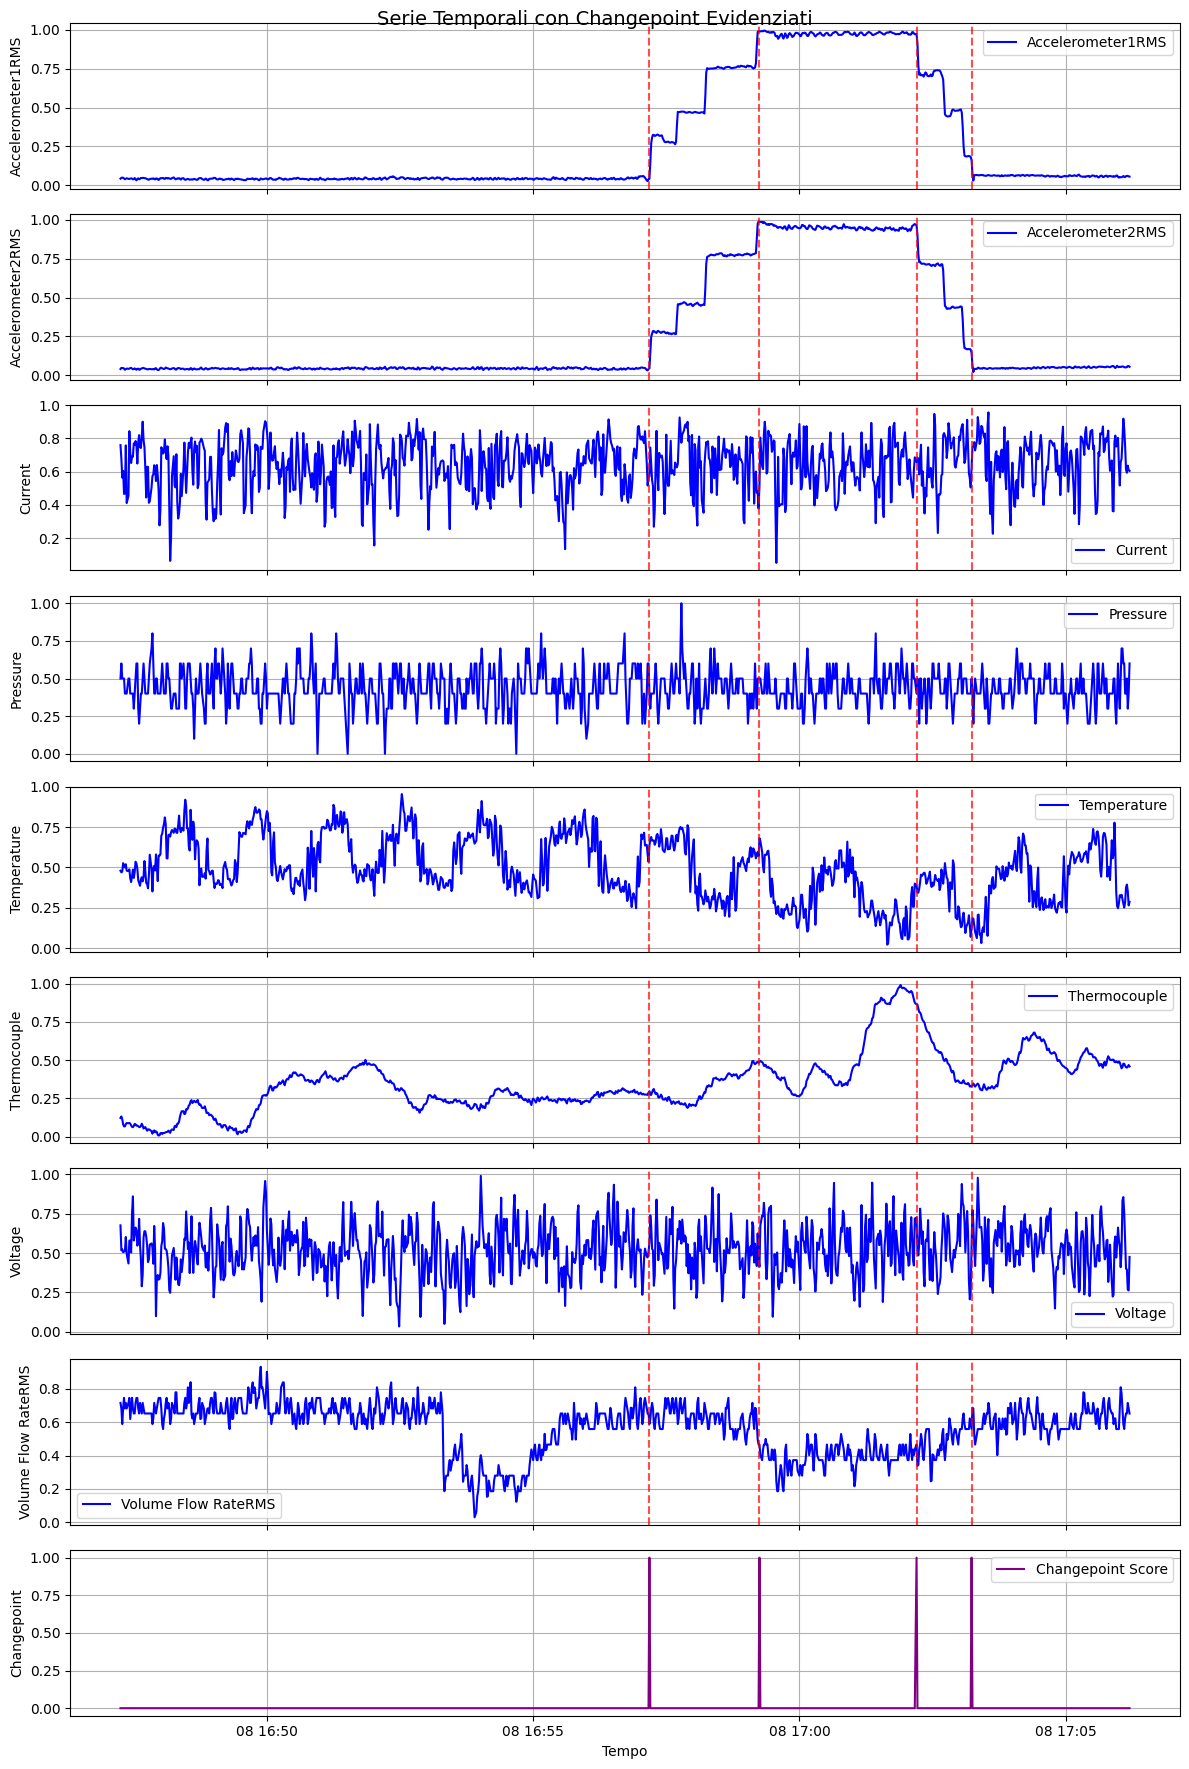

In [7]:
# Dati numerici
numerical_columns = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure', 'Temperature', 
                     'Thermocouple', 'Voltage', 'Volume Flow RateRMS']
df_numeric_an = df[numerical_columns]

# Applica la media mobile con finestra 2
df_moving_avg = df_numeric_an.rolling(window=2).mean().dropna()

# Salva gli indici temporali prima della normalizzazione
df_moving_avg.index = df_moving_avg.index

# Normalizza anche i dati originali
scaler = MinMaxScaler()
df_numeric_an_scaled = pd.DataFrame(scaler.fit_transform(df_numeric_an), columns=numerical_columns, index=df.index)
df_moving_avg_scaled = pd.DataFrame(scaler.transform(df_moving_avg), columns=numerical_columns, index=df_moving_avg.index)

# Filtra intervallo temporale
start_time = "2020-02-08 16:47:15"
end_time = "2020-02-08 17:06:12"
df_filtered = df_moving_avg_scaled.loc[start_time:end_time].copy()

# Aggiunge changepoint e anomaly dal df originale
df_filtered["changepoint"] = df.loc[start_time:end_time, "changepoint"]
df_filtered["anomaly"] = df.loc[start_time:end_time, "anomaly"]

# Trova i changepoint > 0.5
changepoint_indices = df_filtered[df_filtered["changepoint"] > 0.5].index

# Aggiungi inizio e fine
changepoint_indices = [df_filtered.index[0]] + list(changepoint_indices) + [df_filtered.index[-1]]

# Segmentazione
segments = {}
for i in range(len(changepoint_indices) - 1):
    start_idx = changepoint_indices[i]
    end_idx = changepoint_indices[i + 1]
    
    if i > 0:
        try:
            start_idx = df_filtered.index[df_filtered.index.get_loc(start_idx) + 1]
        except IndexError:
            continue

    segment_df = df_filtered.loc[start_idx:end_idx]
    segments[f"segment_{i+1}"] = segment_df

# Visualizza i segmenti
for key, segment in segments.items():
    print(f"{key}: {segment.shape}")
    display(segment.drop(columns=["changepoint"]))

# --- PLOT ---
features = numerical_columns

fig, axes = plt.subplots(len(features) + 1, 1, figsize=(12, 2 * (len(features) + 1)), sharex=True)

for i, feature in enumerate(features):
    axes[i].plot(df_filtered.index, df_filtered[feature], label=feature, color="blue")
    for cp in changepoint_indices[1:-1]:
        axes[i].axvline(x=cp, color="red", linestyle="--", alpha=0.7)
    axes[i].set_ylabel(feature)
    axes[i].legend()
    axes[i].grid()

axes[-1].plot(df_filtered.index, df_filtered["changepoint"], label="Changepoint Score", color="purple")
axes[-1].set_ylabel("Changepoint")
axes[-1].legend()
axes[-1].grid()
axes[-1].set_xlabel("Tempo")

plt.suptitle("Serie Temporali con Changepoint Evidenziati", fontsize=14)
plt.tight_layout()
plt.show()

# **6. Train and Inference**

Segmento 0 - shape dati train: (1880, 8)
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
u:  2
u:  1880
c:  2
c:  8
Segmento 1 - shape dati train: (1880, 8)
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Data: 1880
Centers: 2
Centers: 1880
Data: 8
Dat

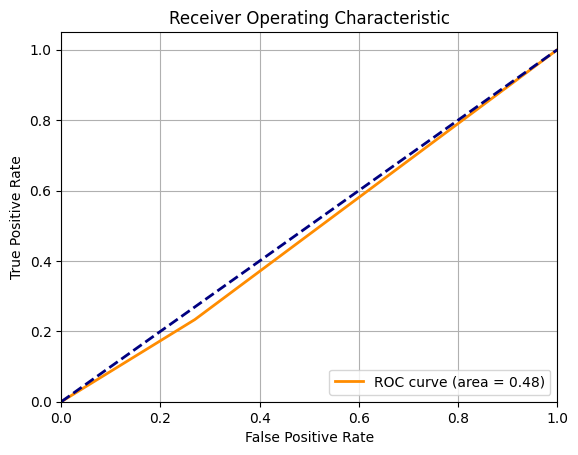


✅ Area sotto la curva (AUC): 0.4821


In [7]:
fuzzy_models = {}
y_true = []

# Allenamento per ogni segmento di dati normali
for i, segment in enumerate(normal_segments):
    
    segment_data = segment.to_numpy()  # shape: (n_features, n_samples)
    
    
    print(f"Segmento {i} - shape dati train:", segment_data.shape)

    n_clusters = 2
    u, c, _, _, _, _, _ = fuzz.cmeans(
        segment_data,
        c=n_clusters,
        m=2.0,
        error=0.005,
        maxiter=1000
    )

    print('u: ', u.shape[0])
    print('u: ', u.shape[1])
    print('c: ', c.shape[0])
    print('c: ', c.shape[1])

    
    fuzzy_models[i] = {
        'centroids': c,          # shape: (n_clusters, n_features)
        'membership': u,
        'n_clusters': n_clusters
    }


test_labels = []
test_membership_scores = []

# Testing su tutti i segmenti
for i, segment in segments.items():
    test_data = segment.iloc[:, :-2].to_numpy().T  # shape: (n_features, n_samples)
    print('row:',test_data.shape[0])
    print('columns:',test_data.shape[1])
    labels = segment.iloc[:, -1].to_numpy()        # etichette reali
    y_true.extend(labels)

    index = int(i.split('_')[-1])  # da 'segment_1' prendi 1
    print(f"\nTesting segmento {i} (index: {index})")

    model = fuzzy_models[index-1]
    centroids = model['centroids']
    print('centroids: ', centroids)
    print("Centroidi shape:", centroids.shape)
    print("Dati test shape:", test_data.shape)

    # Uso dei centroidi per classificare senza ri-addestrare
    print('num_centroids:',centroids.shape[0])
     
    u, _, _, _, _, _ = fuzz.cmeans_predict(
        test_data,
        cntr_trained=centroids,
        m=2.0,
        error=0.005,
        maxiter=1000,
    )
    predicted_labels = np.argmax(u, axis=0)
    test_labels.extend(predicted_labels)

    # Salva la membership del cluster 1 (anomalia), per curva ROC
    test_membership_scores.extend(u[1])  # u[1] = membership del cluster 1

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_true, test_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\n✅ Area sotto la curva (AUC): {roc_auc:.4f}")

In [ ]:
fuzzy_models = {}
y_true = []

# Allenamento per ogni segmento di dati normali
for i, segment in enumerate(normal_segments):
    
    segment_data = segment.to_numpy()  # shape: (n_features, n_samples)
    
    
    print(f"Segmento {i} - shape dati train:", segment_data.shape)

    n_clusters = 2
    u, c, _, _, _, _, _ = fuzz.cmeans(
        segment_data,
        c=n_clusters,
        m=2.0,
        error=0.005,
        maxiter=1000,
        dist_type='quantum'
    )

    print('u: ', u.shape[0])
    print('u: ', u.shape[1])
    print('c: ', c.shape[0])
    print('c: ', c.shape[1])

    
    fuzzy_models[i] = {
        'centroids': c,          # shape: (n_clusters, n_features)
        'membership': u,
        'n_clusters': n_clusters
    }


test_labels = []
test_membership_scores = []

# Testing su tutti i segmenti
for i, segment in segments.items():
    test_data = segment.iloc[:, :-2].to_numpy().T  # shape: (n_features, n_samples)
    print('row:',test_data.shape[0])
    print('columns:',test_data.shape[1])
    labels = segment.iloc[:, -1].to_numpy()        # etichette reali
    y_true.extend(labels)

    index = int(i.split('_')[-1])  # da 'segment_1' prendi 1
    print(f"\nTesting segmento {i} (index: {index})")

    model = fuzzy_models[index-1]
    centroids = model['centroids']
    print('centroids: ', centroids)
    print("Centroidi shape:", centroids.shape)
    print("Dati test shape:", test_data.shape)

    # Uso dei centroidi per classificare senza ri-addestrare
    print('num_centroids:',centroids.shape[0])
     
    u, _, _, _, _, _ = fuzz.cmeans_predict(
        test_data,
        cntr_trained=centroids,
        m=2.0,
        error=0.005,
        maxiter=1000,
        dist_type='quantum'
    )
    predicted_labels = np.argmax(u, axis=0)
    test_labels.extend(predicted_labels)

    # Salva la membership del cluster 1 (anomalia), per curva ROC
    test_membership_scores.extend(u[1])  # u[1] = membership del cluster 1

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_true, test_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\n✅ Area sotto la curva (AUC): {roc_auc:.4f}")

Building Quantum Kernel Matrix: 100%|██████████| 14535/14535 [00:00<00:00, 227566.70it/s]


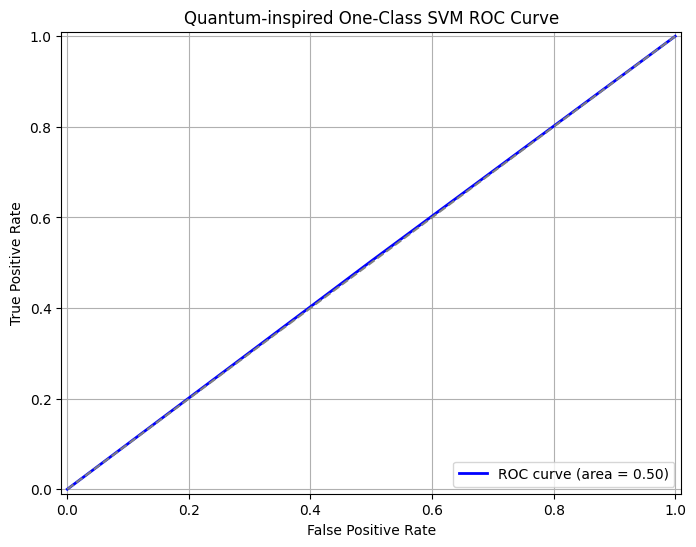

In [24]:
from sklearn.svm import OneClassSVM
from concurrent.futures import ThreadPoolExecutor, as_completed
from qiskit.quantum_info import Statevector
from functools import lru_cache
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

# ⚡ Amplitude Encoding
def amplitude_encoding(vec):
    vec = np.asarray(vec, dtype=float)
    target_len = 1 << (len(vec) - 1).bit_length()
    vec = np.pad(vec, (0, target_len - len(vec)))
    norm = np.linalg.norm(vec)
    return vec / norm if norm != 0 else vec

# ⚡ Cache degli statevector
@lru_cache(maxsize=None)
def get_statevector(vec_tuple):
    vec = np.array(vec_tuple)
    return Statevector(vec)

# ⚡ Fidelity Distance tra due vettori
def simulate_distance_statevector(x_enc, y_vec):
    sv_x = get_statevector(tuple(x_enc))
    y_enc = amplitude_encoding(y_vec)
    sv_y = get_statevector(tuple(y_enc))
    fidelity = np.abs(np.dot(np.conj(sv_x.data), sv_y.data)) ** 2
    return 1 - fidelity  # Distanza = 1 - Fidelity

# ⚡ Kernel Matrix Computation
def compute_kernel_matrix(df, max_workers=8):
    n = len(df)
    kernel_matrix = np.zeros((n, n))
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {}
        for i in range(n):
            x_enc = amplitude_encoding(df.iloc[i].values)
            for j in range(i, n):  # solo triangolo superiore
                futures[executor.submit(simulate_distance_statevector, x_enc, df.iloc[j].values)] = (i, j)
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Building Quantum Kernel Matrix"):
            i, j = futures[future]
            try:
                dist = future.result()
                kernel_matrix[i, j] = dist
                kernel_matrix[j, i] = dist  # simmetrico
            except Exception as e:
                print(f"Errore nel calcolo tra {i} e {j}: {e}")
                kernel_matrix[i, j] = np.nan
                kernel_matrix[j, i] = np.nan

    return kernel_matrix

# 🛠 Costruzione kernel matrices, training SVM e prediction
all_predictions = []
all_labels = []

for key, content in segments.items():
    df = content.iloc[:, :-2]
    labels = content.iloc[:,-1:]
    
    kernel_matrix = compute_kernel_matrix(df)
    
    svm = OneClassSVM(kernel='precomputed')
    svm.fit(kernel_matrix)
    
    preds = svm.predict(kernel_matrix)
    
    all_predictions.append(preds)
    all_labels.append(labels)

# 📊 Unione di tutto
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)

# 🎯 Calcolo ROC curve
fpr, tpr, thresholds = roc_curve(all_labels.astype(int), all_predictions.astype(int))
roc_auc = auc(fpr, tpr)

# 📈 Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Quantum-inspired One-Class SVM ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Callable, Dict, Any, List, Tuple, Optional
import time
import os
import skfuzzy as fuzz
import QFIE.FuzzyEngines as FE
import scipy.linalg as la
from skfuzzy.defuzzify.exceptions import EmptyMembershipError
from sklearn.preprocessing import MinMaxScaler
import membership
import rule_base
import mamdani
import wangmendel
import defuzz
from Examples.MackeyGlass import synthetic
from sklearn.metrics import roc_curve, auc, roc_auc_score
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.circuit.library import Initialize
from qiskit.quantum_info import Pauli, Statevector, state_fidelity
from qiskit_aer import AerError
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_ibm_runtime import EstimatorV2
import seaborn as sns

def load_skab():
        path_to_data = "skab_data/"
        all_files = []
        for root, dirs, files in os.walk(path_to_data):
            for file in files:
                if file.endswith(".csv"):
                    all_files.append(os.path.join(root, file))

        print("Files trovati:")
        for f in all_files:
            print(f)

        list_of_df = [
            pd.read_csv(file, sep=";", index_col="datetime", parse_dates=True)
            for file in all_files if "anomaly-free" not in file
        ]

        anomaly_free_df = pd.read_csv(
            [file for file in all_files if "anomaly-free" in file][0],
            sep=";", index_col="datetime", parse_dates=True
        )

        print(f"\nDataframes caricati:")
        for i, df in enumerate(list_of_df):
            print(f"Dataset {i}: shape = {df.shape}")

        print(f"Anomaly-free dataframe shape: {anomaly_free_df.shape}")

        print("\nEsempio anomaly-free dataframe (prime 5 righe):")
        print(anomaly_free_df.head())

        return list_of_df, anomaly_free_df


list_of_df, anomaly_free_df = load_skab()
# Stampiamo anche i nomi colonne numeriche nel primo dataset non anomaly-free


Files trovati:
skab_data/anomaly-free/anomaly-free.csv
skab_data/other/7.csv
skab_data/other/6.csv
skab_data/other/10.csv
skab_data/other/13.csv
skab_data/other/11.csv
skab_data/other/2.csv
skab_data/other/12.csv
skab_data/other/8.csv
skab_data/other/9.csv
skab_data/other/5.csv
skab_data/other/3.csv
skab_data/other/1.csv
skab_data/other/4.csv
skab_data/other/14.csv
skab_data/valve1/7.csv
skab_data/valve1/6.csv
skab_data/valve1/10.csv
skab_data/valve1/13.csv
skab_data/valve1/11.csv
skab_data/valve1/2.csv
skab_data/valve1/12.csv
skab_data/valve1/8.csv
skab_data/valve1/9.csv
skab_data/valve1/0.csv
skab_data/valve1/5.csv
skab_data/valve1/3.csv
skab_data/valve1/1.csv
skab_data/valve1/4.csv
skab_data/valve1/14.csv
skab_data/valve1/15.csv
skab_data/valve2/2.csv
skab_data/valve2/0.csv
skab_data/valve2/3.csv
skab_data/valve2/1.csv

Dataframes caricati:
Dataset 0: shape = (1090, 10)
Dataset 1: shape = (1147, 10)
Dataset 2: shape = (1327, 10)
Dataset 3: shape = (923, 10)
Dataset 4: shape = (1190,

In [21]:
# Caricamento dati
list_of_df, anomaly_free_df = load_skab()

numerical_columns = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
                         'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

# Preprocessing train (anomaly free)
df_numeric = anomaly_free_df[numerical_columns]
df_moving_avg_n = df_numeric.rolling(window=5).mean().dropna()
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_moving_avg_n), columns=numerical_columns)

train_data = df_scaled.to_numpy()  # (features, samples)


n_clusters = 2
u_train, c_train, _, _, _, _, _ = fuzz.cmeans(
    train_data,
    c=n_clusters,
    m=2.0,
    error=0.005,
    maxiter=1000,
    dist_type='quantum'
)

print('Training done:')
print('u_train shape (membership):', u_train.shape)
print('c_train shape (centroids):', c_train.shape)

aucs = []
aucss = []

# Per ogni dataset anomalo in list_of_df
num_epochs = 30
m = 0
for i, df_anom in enumerate(list_of_df):
    for n in range(num_epochs):
        # Preprocess test
        df_numeric_anom = df_anom[numerical_columns]
        df_moving_avg_anom = df_numeric_anom.rolling(window=5).mean().dropna()

        # Allinea l'indice dopo il rolling
        df_labels = df_anom.loc[df_moving_avg_anom.index]

        # Trasforma con scaler fit sul train
        X_test_scaled = scaler.transform(df_moving_avg_anom)

        print('QUI: ', X_test_scaled.shape[0])
        print(X_test_scaled.shape[1])
        # Labels ground truth anomaly
        y_true = df_labels["anomaly"].to_numpy()

        print("c_train shape:", c_train.shape)           # (n_clusters, n_features)
        print("X_test_scaled.T shape:", X_test_scaled.T.shape)  # (n_features, n_samples)
        # Predizione fuzzy cmeans_predict: input (features, samples)
        u_pred, c, _, _, _, _ = fuzz.cmeans_predict(
            X_test_scaled.T,
            cntr_trained=c_train,
            m=2.0,
            error=0.005,
            maxiter=1000,
            dist_type='quantum'
        )

        # u_pred shape: (n_clusters, n_samples)
        # Assumiamo che cluster con membership più bassa in media è "anomalo" oppure scegli la membership max tra i cluster
        # Qui facciamo membership alla cluster 1 (indice 1) come "anomalia" score (da adattare se serve)
        anomaly_scores = u_pred[1, :]  # membership grado cluster 1

        auc = roc_auc_score(y_true, anomaly_scores)
        print(f"Dataset {i+1} AUC: {auc:.4f}")
        aucs.append((n,auc))
        aucss.append(auc)
    m += 1
    if m == 8:
        break
df_results = pd.DataFrame(aucs, columns=["run", "auc_roc"])
df_results.to_csv("fuzzy_cmeans_auc_results.csv", index=False)
print(f"\nAverage AUC over {len(list_of_df)} datasets: {sum(aucss)/len(aucss):.4f}")

Files trovati:
skab_data/anomaly-free/anomaly-free.csv
skab_data/other/7.csv
skab_data/other/6.csv
skab_data/other/10.csv
skab_data/other/13.csv
skab_data/other/11.csv
skab_data/other/2.csv
skab_data/other/12.csv
skab_data/other/8.csv
skab_data/other/9.csv
skab_data/other/5.csv
skab_data/other/3.csv
skab_data/other/1.csv
skab_data/other/4.csv
skab_data/other/14.csv
skab_data/valve1/7.csv
skab_data/valve1/6.csv
skab_data/valve1/10.csv
skab_data/valve1/13.csv
skab_data/valve1/11.csv
skab_data/valve1/2.csv
skab_data/valve1/12.csv
skab_data/valve1/8.csv
skab_data/valve1/9.csv
skab_data/valve1/0.csv
skab_data/valve1/5.csv
skab_data/valve1/3.csv
skab_data/valve1/1.csv
skab_data/valve1/4.csv
skab_data/valve1/14.csv
skab_data/valve1/15.csv
skab_data/valve2/2.csv
skab_data/valve2/0.csv
skab_data/valve2/3.csv
skab_data/valve2/1.csv

Dataframes caricati:
Dataset 0: shape = (1090, 10)
Dataset 1: shape = (1147, 10)
Dataset 2: shape = (1327, 10)
Dataset 3: shape = (923, 10)
Dataset 4: shape = (1190,

Quantum fidelity distance progress: 100%|██████████| 16/16 [00:00<00:00, 9387.17it/s]


Training done:
u_train shape (membership): (2, 9401)
c_train shape (centroids): (2, 8)
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 183740.31it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 265536.56it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 377461.29it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 383563.99it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 405322.49it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 518558.08it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 360479.12it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 367073.43it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 40234.02it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 364605.31it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 410029.18it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 379552.88it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 320911.24it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 540943.43it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 377931.06it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 183470.18it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 375547.38it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 391559.71it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 362155.77it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 423131.83it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 300492.41it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 373285.32it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 279166.13it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 29042.52it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 275961.11it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 272315.07it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 298044.50it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 459429.54it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 335198.63it/s]


Dataset 1 AUC: 0.9981
QUI:  1086
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1086)


Quantum fidelity distance progress: 100%|██████████| 2172/2172 [00:00<00:00, 374482.19it/s]


Dataset 1 AUC: 0.9981
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 390843.75it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 338326.71it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 419834.44it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 408772.98it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 372790.78it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 365905.17it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 381831.82it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 353103.74it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 502314.49it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 354317.24it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 368209.64it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 337957.03it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 236307.55it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 366016.91it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 345943.82it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 403950.92it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 344328.77it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 530378.30it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 189422.32it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 393458.04it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 364154.16it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 350265.91it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 408529.14it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 271212.60it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 419173.69it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 293989.67it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 320900.26it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 363312.45it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 384080.23it/s]


Dataset 2 AUC: 0.9933
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 305219.93it/s]


Dataset 2 AUC: 0.9933
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 264638.11it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 552448.03it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 484952.08it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 381287.26it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 358570.91it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 478532.61it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 275312.65it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 264575.02it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 349514.33it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 364016.28it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 408740.73it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 368929.21it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 359744.84it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 191113.09it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 398525.15it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 224449.47it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 440961.87it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 559720.01it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 336378.27it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 352937.78it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 383925.29it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 304969.04it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 548678.91it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 412692.56it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 389955.32it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 372470.41it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 364997.97it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 341312.84it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 286388.53it/s]


Dataset 3 AUC: 0.1824
QUI:  1323
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1323)


Quantum fidelity distance progress: 100%|██████████| 2646/2646 [00:00<00:00, 439199.35it/s]


Dataset 3 AUC: 0.1824
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 416282.24it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 266438.47it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 364566.86it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 373341.60it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 344619.17it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 529582.38it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 301798.10it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 363483.93it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 423974.63it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 500592.91it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 347743.73it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 346322.14it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 365864.49it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 381848.07it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 221335.94it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 319033.72it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 370773.89it/s]

Dataset 4 AUC: 0.4553


QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 356030.61it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 353710.98it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 362050.00it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 375286.28it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 377880.04it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 351181.25it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 350765.80it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 524038.53it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 365292.40it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 462677.39it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 420116.12it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 282727.50it/s]


Dataset 4 AUC: 0.4553
QUI:  919
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 919)


Quantum fidelity distance progress: 100%|██████████| 1838/1838 [00:00<00:00, 546940.81it/s]


Dataset 4 AUC: 0.4553
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 352559.95it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 373498.86it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 363522.69it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 295816.16it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 530155.02it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 473756.62it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 440469.70it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 356476.01it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 332327.52it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 362833.30it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 371976.71it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 243929.02it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 369888.43it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 420245.38it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 355533.33it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 293798.22it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 216997.23it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 562529.07it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 391488.18it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 276288.96it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 372701.32it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 356386.63it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 377810.70it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 428868.40it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 37071.95it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 374553.46it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 187343.74it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 380440.10it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 364361.44it/s]


Dataset 5 AUC: 0.9390
QUI:  1186
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1186)


Quantum fidelity distance progress: 100%|██████████| 2372/2372 [00:00<00:00, 411502.22it/s]


Dataset 5 AUC: 0.9390
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 551283.86it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 534490.50it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 376514.54it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 381658.06it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 352974.72it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 375342.20it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 93782.83it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 557229.91it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 545006.68it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 312869.36it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 257254.18it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 355131.47it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 369798.32it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 338299.54it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 258100.78it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 363054.09it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 248039.93it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 220842.71it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 381456.77it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 313336.21it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 342338.14it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 414436.86it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 254448.65it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 252582.64it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 249944.70it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 358455.94it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 354473.96it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 296023.64it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 387843.17it/s]


Dataset 6 AUC: 0.4633
QUI:  776
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 776)


Quantum fidelity distance progress: 100%|██████████| 1552/1552 [00:00<00:00, 359803.22it/s]


Dataset 6 AUC: 0.4633
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 265168.10it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 325021.59it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 307341.88it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 248241.35it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 344439.03it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 449528.12it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 289472.69it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 520672.22it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 348509.96it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 357369.90it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 418808.61it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 350112.21it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 363450.65it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 296539.69it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 330729.11it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 552223.14it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 446116.18it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 231703.75it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 394829.21it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 274691.26it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 361963.49it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 386159.30it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 377682.71it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 283622.86it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 364191.24it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 273798.12it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 359556.05it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 342352.01it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 369165.23it/s]


Dataset 7 AUC: 0.8735
QUI:  1044
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1044)


Quantum fidelity distance progress: 100%|██████████| 2088/2088 [00:00<00:00, 250865.28it/s]


Dataset 7 AUC: 0.8735
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 420903.38it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 537876.08it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 544628.17it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 336770.01it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 153173.14it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 369187.90it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 47077.49it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 328317.32it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 557581.93it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 328508.55it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 360281.78it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 371016.48it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 314872.38it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 366983.54it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 385330.50it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 299705.52it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 242266.44it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 373255.18it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 362447.23it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 359444.38it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 345756.70it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 364292.51it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 375491.64it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 371447.68it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 337433.71it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 376893.83it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 348864.03it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 288878.88it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 261579.02it/s]


Dataset 8 AUC: 0.6167
QUI:  1143
8
c_train shape: (2, 8)
X_test_scaled.T shape: (8, 1143)


Quantum fidelity distance progress: 100%|██████████| 2286/2286 [00:00<00:00, 366030.88it/s]

Dataset 8 AUC: 0.6167

Average AUC over 34 datasets: 0.6902
